# ETH Shock Analysis

## Purpose
Expore how different states(liquidation ratios, liquidity, surplus, etc) affect the risk of bad-debt creation in the Reflexer system by simulating *instantaneous* ETH/USD shocks.
To examine historical ETH shocks see [Historical ETH Shocks](<Historical ETH Shocks.ipynb>)

#### Note: Same as [ETH Shock Simulations and System Debt](<ETH Shock Simulations and System Debt.ipynb>) but uses liquidity-to-debt ratios instead of absolute liquidity amounts.

In [1]:
import time
import math
import pandas as pd
import numpy as np
import requests
import json
import multiprocess
from multiprocess import Pool
from decimal import Decimal
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.preprocessing import PowerTransformer
from web3 import Web3, HTTPProvider

from scipy.stats import multivariate_normal

import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

from uniswap import get_input_price, get_output_price, buy_to_price
from graph_util import fetch_safes, fetch_rp, fetch_debt_ceiling, fetch_saviour_safes
from web3_util import fetch_saviour_targets
from util import chunks

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

## Define Some Sim Functions

In [3]:
def update_cratios(safes, eth_price, redemption_price):
    # update c-ratio based on `eth_price` and `redemption_price`
    new_safes = safes.copy()
    new_safes['cratio'] = new_safes['collateral'] * eth_price / (new_safes['debt'] * redemption_price)
    return new_safes

In [4]:
def liquidate_critical(safes, liq_cratio=1.35):
    """
    Returns the total amount of collateral and debt of `safes` that have a c-ratio 
    less than are `liq_cratio`
    Parameters
    ----------
    safes: pd.DataFrame
        SAFEs dataframe
    liq_cratio: float
        liquidation c-ratio parameter of the system
    Returns
    --------
    critical_collatera, critical_debt: float, float
        Amount of collateral and debt belonging to liquidated SAFEs
    """

    critical_safes = safes.query(f'cratio < {liq_cratio}')
    critical_collateral, critical_debt = critical_safes[['collateral', 'debt']].sum()
    
    return critical_collateral, critical_debt

def adjust_safe_debt_and_cratios(safes, debt_adj, eth_price, redemption_price):
    # adjust debt by `debt_adj` multiplier
    # `debt_adj` is used to adjust individual SAFE debt to match expected values when system liq_ratio is changed
    # This preserves safe debt as a multiplier of liq_ratio
    if debt_adj == 1:
        return safes
    new_safes = safes.copy()
    
    new_safes['debt'] *= debt_adj

    return update_cratios(new_safes, eth_price, redemption_price)

## Fetch Data

In [5]:
#graphql_url = 'https://subgraph.reflexer.finance/subgraphs/name/reflexer-labs/rai'
graphql_url = 'https://api.thegraph.com/subgraphs/name/reflexer-labs/rai-mainnet'
eth_usd_url = 'https://api.coingecko.com/api/v3/simple/price?ids=ethereum&vs_currencies=usd'
ETH_RPC_URL = 'https://mainnet.infura.io/v3/71de86fb79e940a7970bad3f43c0da4e'

web3 = Web3(HTTPProvider(endpoint_uri=ETH_RPC_URL))

ETH_USD = requests.get(eth_usd_url).json()['ethereum']['usd']
REDEMPTION_PRICE = fetch_rp(graphql_url)
DEBT_CEILING = fetch_debt_ceiling(graphql_url)

# get saviour safes from graph
saviour_safes = fetch_saviour_safes(graphql_url)

# get LP info not available in graph
saviour_safes = fetch_saviour_targets(web3, saviour_safes)

orig_safes = fetch_safes(graphql_url)

In [6]:
orig_safes.head(5)

,collateral,debt,safeId
0,0.0,0.0,1133
1,0.0,0.0,1753
2,0.0,0.0,878
3,0.0,0.0,1352
4,0.0,0.0,1927


In [7]:
# only consider SAFEs with debt
orig_safes = orig_safes.query('debt > 0').reset_index(drop=True)
saviour_safes = saviour_safes.query('debt > 0').reset_index(drop=True)

In [8]:
orig_safes['safeId'] = orig_safes['safeId'].astype(int)
saviour_safes['safeId'] = saviour_safes['safeId'].astype(int)

In [9]:
both_safes = pd.merge(orig_safes, saviour_safes, on='safeId', how='outer', indicator=True)
non_saviour_safes = both_safes.query('_merge == "left_only"').reset_index(drop=True)\
                    .rename({'collateral_x': 'collateral', 'debt_x': 'debt'}, axis=1)\
                    [['collateral', 'debt', 'safeId']]

## Mainnet Parameters

In [10]:
MAINNET_LIQ_RATIO = 1.35 
LIQ_PENALTY = 1.10
MIN_DISCOUNT = 0.92
MAX_DISCOUNT = 0.90
MAINNET_SURPLUS_PCT = 533E3/DEBT_CEILING
 
# use max_discount for collateral_auctions
DISCOUNT = MAX_DISCOUNT

# What percent of SAFE owners avoid liquidation with OSM delay
OSM_RESPONSIVENESS = 0.50 

# RAI pools
# used only for Sim #1 that only uses Mainnet safe data, not simulated
RAI_ETH_V2 = 1.645E6

RAI_DAI_V3 = 870E3 
RAI_USDC_V3 =  150E3

CURVE = 12.1E6

rai_v2_pool = RAI_ETH_V2
usd_v2_pool = rai_v2_pool * REDEMPTION_PRICE

# include curve amount as v3 pool, which assumes 1% slippage
rai_v3_pool = RAI_DAI_V3 + RAI_USDC_V3 + CURVE
usd_v3_pool = rai_v3_pool * REDEMPTION_PRICE

#### Not currently used
SURPLUS_BUFFER = 500000 # Not currently used
DISCOUNT_UPDATE_RATE = Decimal(0.999991859697312485818842992) # Not currently used
LIQUIDATION_QUANTITY = 90000.00 # Not currently used
ON_AUCTION_SYSTEM_COIN_LIMIT = 4025086.73 # Not currently used
#####


## Sim Parameters

In [11]:
# Number of runs per shock
# If 1, RAI/ETH responses will not be stochastic
N_SHOCK_RUNS = 1 

# Uncomment when modeling with only V2
#N_SHOCK_RUNS = 10

# Number of different SAFE populations to generate
# Shocks of different magnitude will be simulated for each population
N_SAFE_POPS = 200
SAFE_POP_SEEDS = np.random.randint(0, 1E6, size=N_SAFE_POPS)

# All pool to debt ratios to simulate
V2_POOL_DEBTS = np.round(np.linspace(0.05, 0.30, 20), 3)
V3_POOL_DEBTS = np.round(np.linspace(0.05, 0.30, 20), 3)

# All starting surplus pcts to simulate
# set as percent of DEBT_CEILING
INITIAL_SURPLUS_PCTS = [0.005]

# All collateral shocks to simulate
min_shock = 0.10
max_shock = 0.40
n_shocks = int((max_shock - min_shock) * 100) + 1 #31

SHOCKS = np.round(np.linspace(min_shock, max_shock, n_shocks), 4)
TOTAL_SHOCKS = [1] # Number of shocks to run in succession, not currently used

# Analysis Parameters
# quantiles to report. ie. probability of bad debt
QUANTILES = [0.95]

## Overview

Explore bad debt creation during ETH/USD price dops.

## Methodology

Simulate an ETH/USD price drop of X%, then use RAI from Uniswap pools to settle resulting collateral auction and determine how much bad debt is created.

## Simulations

1) Mainnet collateral amounts and c-ratios

2) Mainnet collateral amounts and stochastic c-ratios

3) Stochastic collateral amounts and stochastic c-ratios

4) Gaussian Mixture model for collateral amounts and c-ratios


## Assumptions
1) All RAI for collateral auctions is purchased from the market. No RAI-holding keepers exist
2) No RAI selling pressure during collateral shocks.
Worst case RAI market price.  Keepers get worse deal for RAI than expected and can thus buy less collateral at a profit in collateral auctions.
3) Saviours only considered in Sim #1.
4) 50% OSM Responsiveness. 
Only 50% of SAFEs avoid liquidation through OSM ETH/USD price delay
5) Gas prices are not considered
6) Non Uniswap V2 slippage(Uni V3, Curve) is estimated at 1%

In [12]:
# run a single sim
def run(safes, saviour_safes, liq_ratio, rai_v2_pool,
        rai_v3_pool, eth_shock_price, initial_surplus_pct, rai_usd_shock=1.0, verbose=False):
    
    initial_surplus = initial_surplus_pct * DEBT_CEILING
    #print(f"{initial_surplus=}")
    if len(saviour_safes) > 0:
        #saviour_safes = update_cratios(saviour_safes, eth_shock_price, REDEMPTION_PRICE)  
        
        # total syscoin removed from pool by saviours        
        syscoin_lp = saviour_safes[saviour_safes['cratio'] < liq_ratio]['lp_syscoin'].sum()
        rai_v2_pool_left = rai_v2_pool - syscoin_lp
    else:
        rai_v2_pool_left = rai_v2_pool 

    # Liquidate all critical SAFEs
    critical_collateral, critical_debt = liquidate_critical(safes, liq_ratio)
    
    critical_collateral *= (1 - OSM_RESPONSIVENESS)
    critical_debt *= (1 - OSM_RESPONSIVENESS)
    
    amount_to_raise = critical_debt * LIQ_PENALTY
    if verbose:
        print(f"{critical_collateral=:.0f}, {critical_debt=:.0f}, {amount_to_raise=:.2f}")
        
    discount_collateral_price = eth_shock_price * DISCOUNT
    
    total_collateral_cost = critical_collateral * discount_collateral_price
    
    # Use v3 pool 
    
    # Assume rai market = redemption price and estimate slippage
    # TODO: improve
    rai_v3_market_price = REDEMPTION_PRICE * 1.01 # Estimate slippage in V3 pool.

    # Use up to the entire pool to buy discounted collateral
    v3_collateral_bought = min((rai_v3_pool * REDEMPTION_PRICE)/discount_collateral_price, critical_collateral) 

    collateral_left = critical_collateral - v3_collateral_bought

    rai_v3_spent = v3_collateral_bought * discount_collateral_price / REDEMPTION_PRICE

    amount_raised_v3 = rai_v3_spent

    if verbose:
        print(f"{amount_raised_v3=:0f}")
        
    if collateral_left == 0:
        amount_deficit = critical_debt - amount_raised_v3

    else: # then use V2 pool

        amount_left_to_raise = amount_to_raise - rai_v3_spent
        
        if verbose:
            print(f"Using V2 pool. {amount_left_to_raise=:.0f}")
            
        collateral_left_cost = collateral_left * discount_collateral_price

        # max price to pay for RAI to make a profit on discounted collateral
        max_market_price = REDEMPTION_PRICE / DISCOUNT
        
        current_market_price = REDEMPTION_PRICE * rai_usd_shock
        #print(f"{eth_shock_price=}, {current_market_price=}")

        # Max amount to buy to put cost-basis at `max_market_price`
        how_much_v2_can_buy = 2 * buy_to_price(None, rai_v2_pool_left,
                                               goal_price=max_market_price,
                                               market_price=current_market_price)
                                               #market_price=REDEMPTION_PRICE)
        
        # how is the pool affected with this swap
        # This just confirms the expected final market price
        #delta_usd, delta_rai = get_output_price(how_much_v2_can_buy, usd_v2_pool, rai_v2_pool, trade_fee=0.003)
        # new market price
        #print(f"market price after buy {(usd_v2_pool + delta_usd)/(rai_v2_pool + delta_rai):.2f}")

        amount_raised_v2 = min(amount_left_to_raise, how_much_v2_can_buy)

        amount_deficit = critical_debt - amount_raised_v2 - amount_raised_v3
        #print(f"{how_much_v2_can_buy=:2f}, {amount_raised_v2=:2f}, {amount_deficit=:2f}")

    if verbose:
        print(f"{amount_deficit=:2f}")
        
    return initial_surplus - amount_deficit

In [13]:
# run many sims over multiple shocks
def run_sims_iter(safes, v2_pool_debts, v3_pool_debts, initial_surplus_pcts, shocks=[], rai_returns={},
                  liq_ratio=1.35, title='', sim_name='', verbose=False):
    all_results = []
    
    # cross product
    for v2_liq_debt, v3_liq_debt in [(x, y) for x in v2_pool_debts for y in v3_pool_debts]:
        #if v2_liq_debt == v3_liq_debt == 0: # no liquidity
        #    continue
        for initial_surplus_pct in initial_surplus_pcts:
            config_shocks = []
            config_surpluses = []
            config_safe_pops = []
            
            # for each safe population
            for i, run_safes in enumerate(safes):
                debt_usd = run_safes['debt'].sum()
                collateral = run_safes['collateral'].sum()
                rai_v2_pool = v2_liq_debt * debt_usd
                rai_v3_pool = v3_liq_debt * debt_usd
                plot_surpluses = []
                # for each shock
                for s in shocks:
                    # Set eth shock price and update-cratios
                    eth_shock_price = ETH_USD * (1 - s)
                    updated_safes = update_cratios(run_safes, eth_shock_price, REDEMPTION_PRICE) 
                    #updated_saviour_safes = update_cratios(saviour_safes, eth_shock_price, REDEMPTION_PRICE)  
                    # for each rai/usd shock
                    for rai_usd_shock in rai_returns[s]: 
                        
                        run_surplus = run(updated_safes, [], liq_ratio=liq_ratio,
                                          rai_v2_pool=rai_v2_pool, rai_v3_pool=rai_v3_pool,
                                          eth_shock_price=eth_shock_price, rai_usd_shock=rai_usd_shock,
                                          initial_surplus_pct=initial_surplus_pct, verbose=verbose)
                        if verbose:
                            print(f"{i=}, {v2_liq_debt=}, {v2_liq_debt=}, shock={-s}, {rai_usd_shock=:.2f}, {run_surplus=:.2f}") 
                        
                        config_shocks.append(s)
                        config_surpluses.append(run_surplus)   
                        config_safe_pops.append(i)
                        
                        if s == 0.0 and run_surplus < 0:
                            raise ValueError("negative surplus at zero shock")

            df = pd.DataFrame({'sim_name': sim_name, 'lr': liq_ratio, 'v2_liq_debt': v2_liq_debt,# static config values
                               'v3_liq_debt': v3_liq_debt, 'initial_surplus_pct': initial_surplus_pct, # static config values
                               'safe_pop': config_safe_pops,
                               'shock': config_shocks,  'surplus': config_surpluses})
            
            print(f"{v2_liq_debt=}, {v3_liq_debt=}, {liq_ratio=}, {initial_surplus_pct=} complete")
            all_results.append(df)
                
    return pd.concat(all_results)


# Sim #1: Mainnet SAFE Collateral Amounts and C-ratios
Sim #1 uses static liquidity amounts set above to simulate drops with existing, mainnet SAFE population

### Compare Mainnet Saviour Safes to Non-Saviour

In [14]:
print(f"percent of mainnet collateral w/ saviours: {saviour_safes['collateral'].sum() /orig_safes['collateral'].sum():.2f}")

percent of mainnet collateral w/ saviours: 0.05


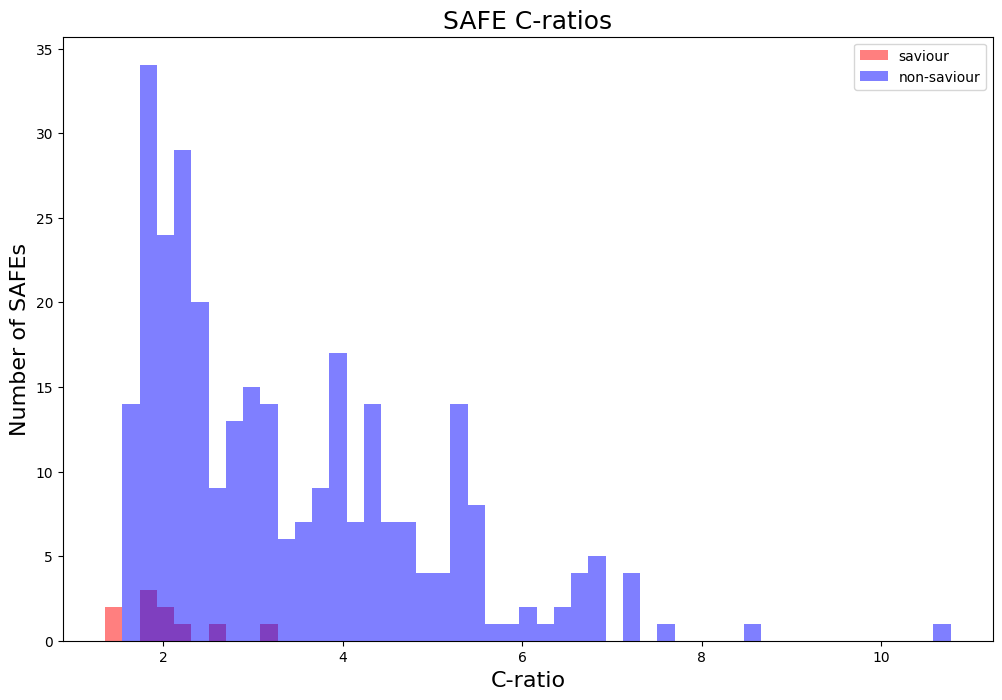

In [15]:
saviour_safes = update_cratios(saviour_safes, ETH_USD, REDEMPTION_PRICE)
non_saviour_safes = update_cratios(non_saviour_safes, ETH_USD, REDEMPTION_PRICE)

orig_safes = update_cratios(orig_safes, ETH_USD, REDEMPTION_PRICE)
bins = np.linspace(1.35, orig_safes['cratio'].max(), 50)

saviour_safes['cratio'].hist(bins=bins, alpha=0.5, color='red', label='saviour')

non_saviour_safes['cratio'].hist(bins=bins, color='blue', alpha=0.5, label='non-saviour')

#orig_safes['cratio'].hist(bins=bins, color='green', alpha=0.2, label='all safes')

plt.title('SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

### Simulate ETH/USD shocks against mainnset SAFEs, w/ and w/o saviours

Saviours automatically withdraw Uniswap V2 liquidity when their SAFE is critical. Let's observe the affect this has on the system as a whole during shocks.
If the primary source of protocol liquidity is Uniswap V2, saviours increase chance of bad debt creation.

In [16]:
# set shocks for mainnet sim #1 only
min_shock = 0.10
max_shock = 0.60
n_shocks = int((max_shock - min_shock) * 100) + 1 #31

SIM1_SHOCKS = np.round(np.linspace(min_shock, max_shock, n_shocks), 4)

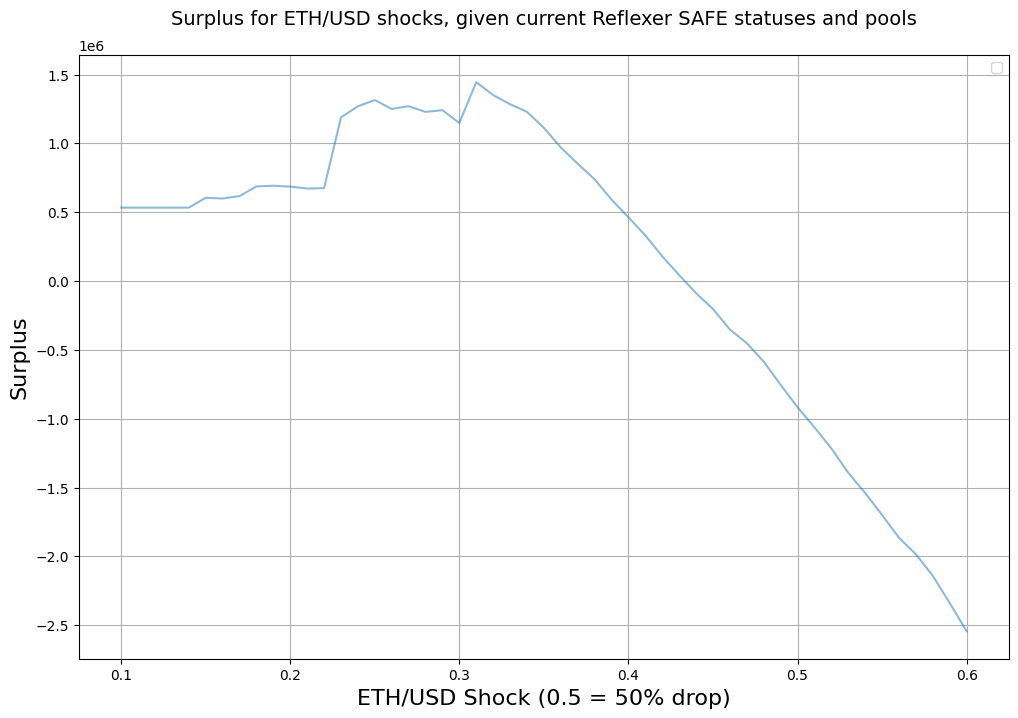

In [240]:
all_debt_usd = (non_saviour_safes['debt'].sum() + saviour_safes['debt'].sum()) * REDEMPTION_PRICE

# with saviours
# saviours automatically withdraw V2 LP when debt is critical
surpluses = []
for s in SIM1_SHOCKS:
    eth_shock_price = ETH_USD * (1 - s)
    shock_safes = update_cratios(non_saviour_safes, eth_shock_price, REDEMPTION_PRICE)
    shock_saviour_safes = update_cratios(saviour_safes, eth_shock_price, REDEMPTION_PRICE)

    surplus = run(shock_safes, shock_saviour_safes, liq_ratio=MAINNET_LIQ_RATIO,
                  rai_v2_pool=rai_v2_pool, 
                  rai_v3_pool=rai_v3_pool,
                  eth_shock_price=eth_shock_price, 
                  initial_surplus_pct=MAINNET_SURPLUS_PCT, verbose=False)
    
    surpluses.append(surplus)
    
#plt.plot(SIM1_SHOCKS, surpluses, alpha=0.5, label='considering saviours')
plt.plot(SIM1_SHOCKS, surpluses, alpha=0.5, label='')

"""
# without saviours
surpluses_wo = []
for s in SIM1_SHOCKS:
    eth_shock_price = ETH_USD * (1 - s)
    shock_safes = update_cratios(non_saviour_safes, eth_shock_price, REDEMPTION_PRICE)
    shock_saviour_safes = update_cratios(saviour_safes, eth_shock_price, REDEMPTION_PRICE)

    surplus = run(shock_safes, [], liq_ratio=MAINNET_LIQ_RATIO,
                  rai_v2_pool=rai_v2_pool, 
                  rai_v3_pool=rai_v3_pool,
                  eth_shock_price=eth_shock_price, 
                  initial_surplus_pct=MAINNET_SURPLUS_PCT, verbose=False)
    
    surpluses_wo.append(surplus)
    
plt.plot(SIM1_SHOCKS, surpluses_wo, alpha=0.5, label='w/o saviours')
""" 
plt.legend()
plt.title('Surplus for ETH/USD shocks, given current Reflexer SAFE statuses and pools\n', fontsize=14)
plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
plt.ylabel('Surplus', fontsize=16)
plt.grid(True)
plt.show()


# Sim #2: Mainnet SAFE Collateral Amounts with Stochastic C-ratios

### Examine mainnet c-ratios

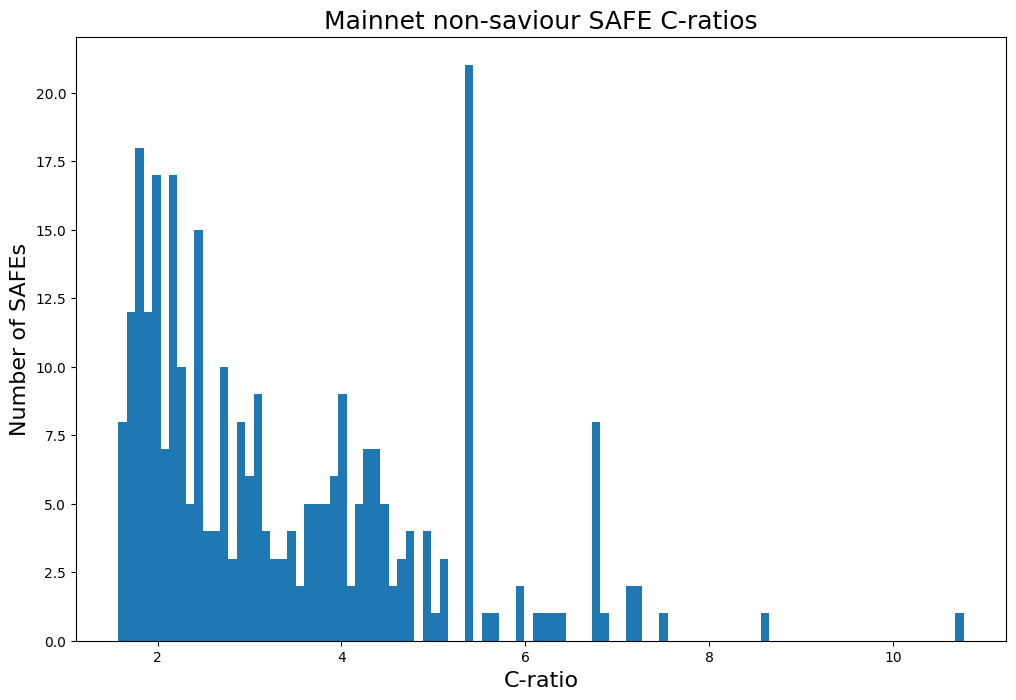

In [18]:
non_saviour_safes = update_cratios(non_saviour_safes, ETH_USD, REDEMPTION_PRICE)
non_saviour_safes['cratio'].hist(bins=100)
plt.title('Mainnet non-saviour SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.grid(False)
plt.show()

### Fit many distributions to mainnnet c-ratios

,sumsquare_error,aic,bic,kl_div
skewnorm,1.224441,725.560579,-1626.788338,inf


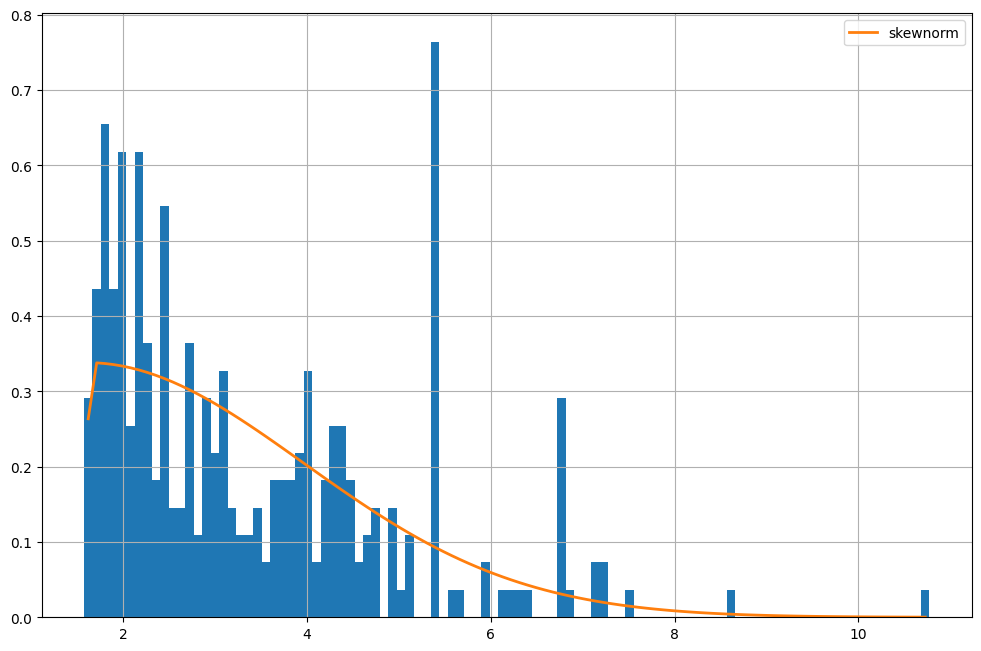

In [19]:
fitter_cratio = Fitter(non_saviour_safes['cratio'].values,
                       distributions=['skewnorm'])         
fitter_cratio.fit()
fitter_cratio.summary()

### Pick the best distribution and generate some c-ratios

In [20]:
best_cratio = fitter_cratio.get_best(method = 'sumsquare_error')
best_cratio_params = list(list(best_cratio.values())[0].values())
best_cratio_params
best_function_name = list(best_cratio.keys())[0]
print(f"{best_function_name=}, {best_cratio_params=}")
ss_best_cratio_function = getattr(ss, best_function_name)

best_function_name='skewnorm', best_cratio_params=[88.6611258507661, 1.5988488062204453, 2.3601573349994256]


In [21]:
non_saviour_safes['cratio'].head(3)

0    4.041435
1    6.196493
2    3.562494
Name: cratio, dtype: float64

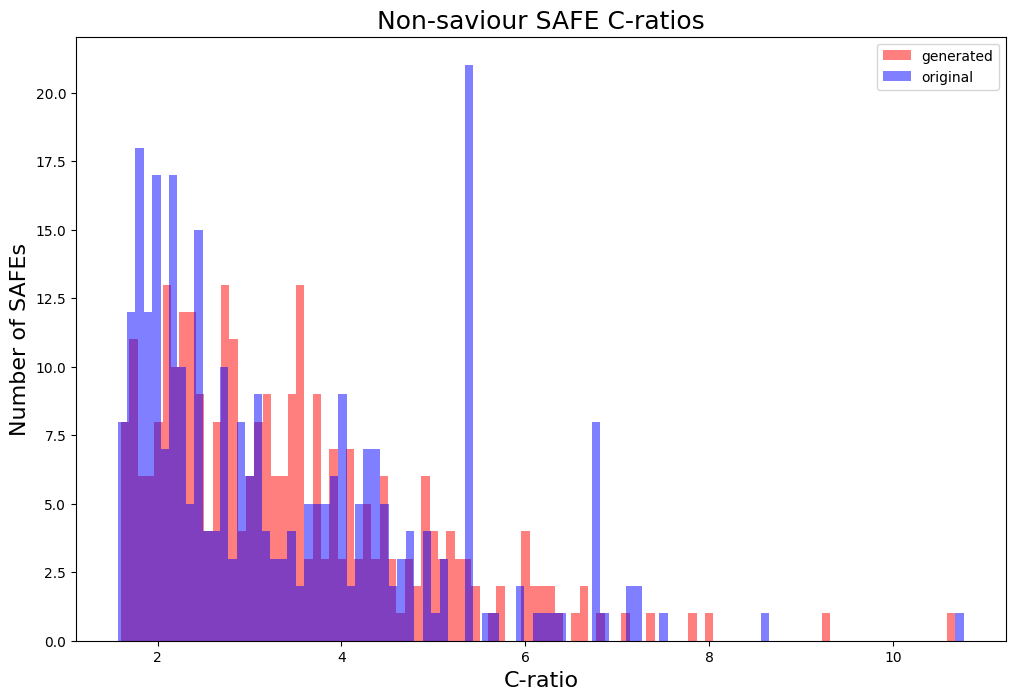

In [22]:
cratios_r = ss_best_cratio_function.rvs(*best_cratio_params,  size=len(non_saviour_safes)*2, random_state=42)
cratios_r = cratios_r[cratios_r > MAINNET_LIQ_RATIO]

df = pd.DataFrame(cratios_r, columns=['cratio'])
df = df.head(len(non_saviour_safes))

df['cratio'].hist(bins=100, alpha=0.5, color='red', label='generated')

non_saviour_safes['cratio'].hist(bins=100, color='blue', alpha=0.5, label='original')

plt.title('Non-saviour SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

### Prepare Sim #2 SAFEs

In [23]:
# Generate twice as many cratios to ensure we have enough greater than liq ratio

all_cratios = [ss_best_cratio_function.rvs(*best_cratio_params, size=len(non_saviour_safes)*2, random_state=SAFE_POP_SEEDS[i])
               for i in range(N_SAFE_POPS)]

cratio_rv = ss_best_cratio_function(*best_cratio_params)

all_tmp_safes = [pd.DataFrame(cr, columns=['cratio']) for cr in all_cratios]

final_sim2_safes = []
for tmp_safes in all_tmp_safes:
    # remove generates c-ratios that are less than liq ratio
    # and ensure there are still enough
    tmp_safes = tmp_safes[tmp_safes['cratio'] > MAINNET_LIQ_RATIO]        
    tmp_safes = tmp_safes.head(len(non_saviour_safes))
    assert len(tmp_safes) == len(non_saviour_safes)

    tmp_safes['collateral'] = non_saviour_safes['collateral']
    tmp_safes['debt'] = tmp_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / tmp_safes['cratio']

    # Consider debt ceiling, adding more possible debt
    extra_debt = DEBT_CEILING  - tmp_safes['debt'].sum()
    print(f"filling {extra_debt=}")
    added_debt = 0
    seed = 0
    while added_debt < extra_debt and extra_debt > 0:
        seed += 1
        new_cr = cratio_rv.rvs(size=1, random_state=seed)[0]
        while new_cr < MAINNET_LIQ_RATIO: 
            seed += 1
            new_cr = cratio_rv.rvs(size=1, random_state=seed)[0]
            
        new_coll = non_saviour_safes['collateral'].sample().iloc[0]

        new_debt = min(new_coll * ETH_USD / REDEMPTION_PRICE / new_cr, extra_debt - added_debt)
        added_debt += new_debt
        tmp_safes = tmp_safes.append({'cratio': new_cr, 'collateral': new_coll, 'debt': new_debt}, ignore_index=True)
        
    final_sim2_safes.append(tmp_safes)        
    assert added_debt == extra_debt or extra_debt < 0

filling extra_debt=18422916.013617717
filling extra_debt=12538736.711623617
filling extra_debt=15588427.621367019
filling extra_debt=16255673.809850276
filling extra_debt=13596501.565875579
filling extra_debt=13735443.148832314
filling extra_debt=15977035.418852072
filling extra_debt=14120537.674256794
filling extra_debt=13181093.795462966
filling extra_debt=15955547.019567784
filling extra_debt=16136749.609315872
filling extra_debt=14479676.536588207
filling extra_debt=14901515.384262491
filling extra_debt=15671729.806160655
filling extra_debt=12777111.439676173
filling extra_debt=12533095.28257244
filling extra_debt=13108427.753288426
filling extra_debt=12229192.564455558
filling extra_debt=15704207.256275047
filling extra_debt=14691022.392187886
filling extra_debt=15252023.48044759
filling extra_debt=12324037.039556839
filling extra_debt=16512122.932239436
filling extra_debt=15143182.076986965
filling extra_debt=16817902.785257064
filling extra_debt=14688115.637787659
filling extra_

# Sim #3: Stochastic SAFE collateral amounts and stochastic c-ratios

### Fit many distributions to mainnnet collateral amounts

,sumsquare_error,aic,bic,kl_div
skewcauchy,1.541801,561.547469,-1557.878803,inf


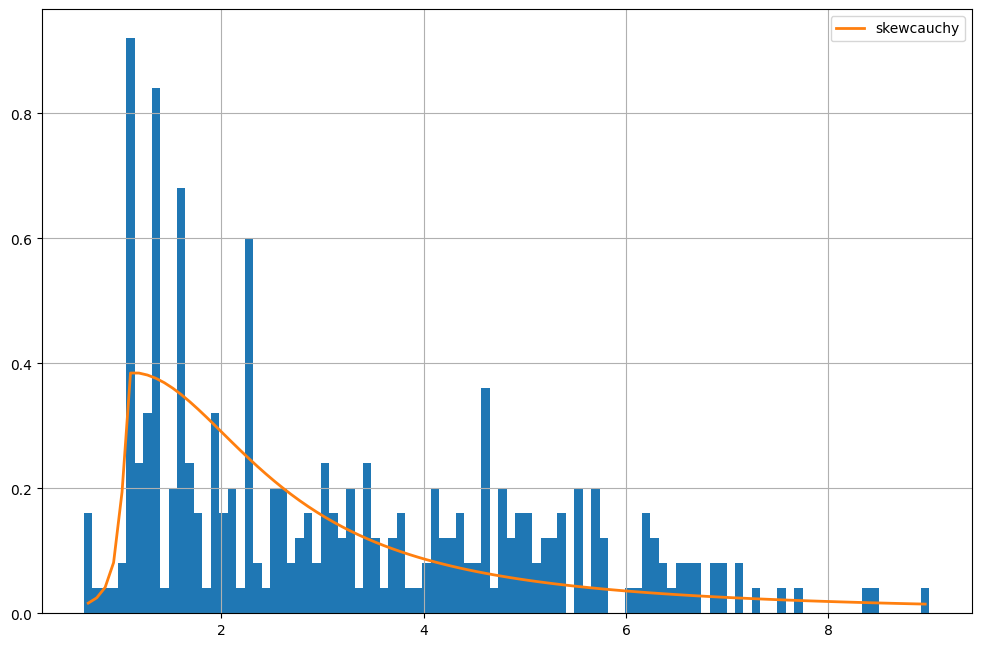

In [24]:
fitter_coll = Fitter(np.log(non_saviour_safes['collateral'].values),
                     distributions=['skewcauchy']) 
                     
fitter_coll.fit()
fitter_coll.summary()

### Pick the best distribution and generate some collateral amounts

In [25]:
best_coll = fitter_coll.get_best(method = 'sumsquare_error')
best_coll_params = list(list(best_coll.values())[0].values())
best_coll_params
best_function_name = list(best_coll.keys())[0]
print(f"{best_function_name=}, {best_coll_params=}")
ss_best_coll_function = getattr(ss, best_function_name)

best_function_name='skewcauchy', best_coll_params=[0.8928654010252217, 1.1057709773796258, 0.8258952893922171]


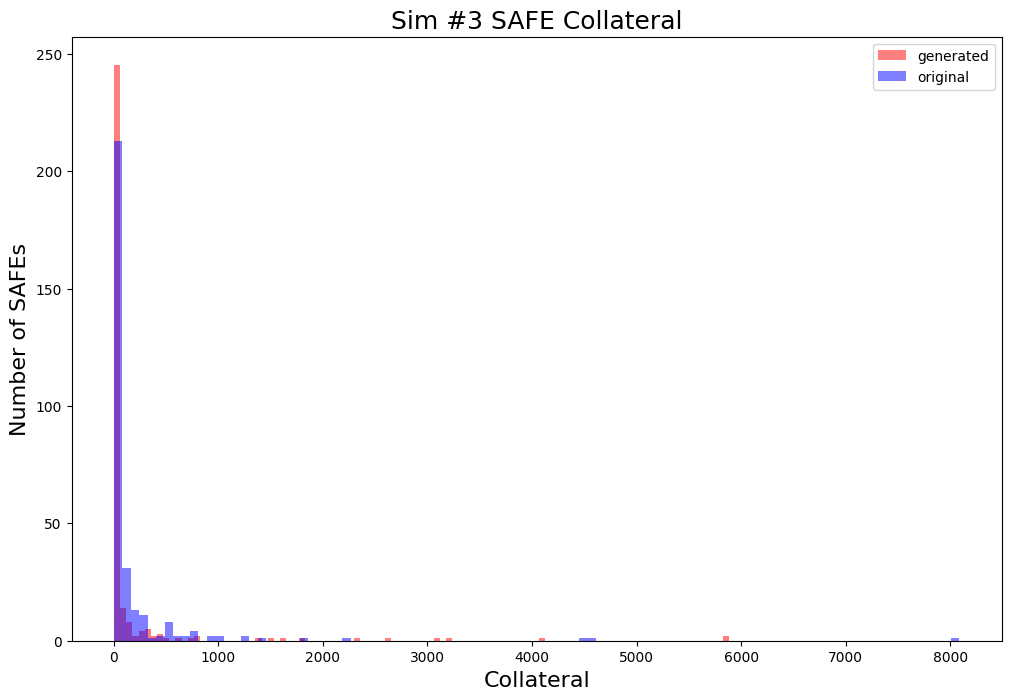

In [26]:
colls_r = ss_best_coll_function.rvs(*best_coll_params, size=len(non_saviour_safes)*2, random_state=42)

colls_r = np.exp(colls_r)

# Collateral
df = pd.DataFrame(colls_r, columns=['collateral'])
df = df[(df['collateral'] > 0) & (df['collateral'] < non_saviour_safes['collateral'].max()) & (tmp_safes['cratio'] > MAINNET_LIQ_RATIO)]
df = df.head(len(non_saviour_safes))

df['collateral'].hist(bins=100, alpha=0.5, color='red', label='generated')

non_saviour_safes['collateral'].hist(bins=100, color='blue', alpha=0.5, label='original')
#plt.xlim([0, 1000])
plt.title('Sim #3 SAFE Collateral', fontsize=18)
plt.xlabel('Collateral', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

### Prepare Sim #3 SAFEs

In [27]:
all_cratios = [ss_best_cratio_function.rvs(*best_cratio_params, size=len(non_saviour_safes)*2, random_state=SAFE_POP_SEEDS[i])
               for i in range(N_SAFE_POPS)]

all_collaterals = [np.exp(ss_best_coll_function.rvs(*best_coll_params, 
                                            size=len(non_saviour_safes)*2, random_state=SAFE_POP_SEEDS[i]))
                   for i in range(N_SAFE_POPS)]

cratio_rv = ss_best_cratio_function(*best_cratio_params)
coll_rv = ss_best_coll_function(*best_coll_params)

all_tmp_safes = [pd.DataFrame({'collateral': coll, 'cratio': cr})  for coll, cr in zip(all_collaterals, all_cratios)]

# bound stochasticly generated collaterals
max_collateral = non_saviour_safes['collateral'].max()
final_sim3_safes = []
seed = 0
for tmp_safes in all_tmp_safes:
    tmp_safes = tmp_safes[(tmp_safes['collateral'] > 0) & (tmp_safes['collateral'] < max_collateral) & (tmp_safes['cratio'] > MAINNET_LIQ_RATIO)]
    tmp_safes = tmp_safes.head(len(non_saviour_safes))
    assert len(tmp_safes) == len(non_saviour_safes)
    tmp_safes['debt'] = tmp_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / tmp_safes['cratio']
    
    # calculate and fill remaining debt
    extra_debt = DEBT_CEILING  - tmp_safes['debt'].sum()
    added_debt = 0
    print(f"filling {extra_debt=}")
    while added_debt < extra_debt and extra_debt > 0:
        seed += 1
        # Sample c-ratios and collateral amounts for valid values
        new_cr = cratio_rv.rvs(size=1, random_state=seed)[0]
        while new_cr < MAINNET_LIQ_RATIO: 
            seed += 1
            new_cr = cratio_rv.rvs(size=1, random_state=seed)[0]
            
        new_coll = np.exp(coll_rv.rvs(size=1, random_state=seed))[0]
        while new_coll > max_collateral:
            seed += 1
            new_coll = np.exp(coll_rv.rvs(size=1, random_state=seed))[0]
                 
        # calculate debt
        # if debt will exceed debt ceiling, reduce
        new_debt = min(new_coll * ETH_USD / REDEMPTION_PRICE / new_cr, extra_debt - added_debt)
        added_debt += new_debt
                
        # Add new SAFE
        tmp_safes = tmp_safes.append({'cratio': new_cr, 'collateral': new_coll, 'debt': new_debt}, ignore_index=True)
        
    assert added_debt == extra_debt or extra_debt < 0
    final_sim3_safes.append(tmp_safes)   

filling extra_debt=16891257.89741725
filling extra_debt=8794816.995149195
filling extra_debt=21485598.853679344
filling extra_debt=16489785.492712438
filling extra_debt=15905504.301749356
filling extra_debt=23190492.650199253
filling extra_debt=15370237.989017531
filling extra_debt=17921780.00846115
filling extra_debt=13075233.937117994
filling extra_debt=14184671.30692292
filling extra_debt=10340131.235481545
filling extra_debt=7838515.261954397
filling extra_debt=13913177.534047186
filling extra_debt=11154725.937972844
filling extra_debt=12775394.240303997
filling extra_debt=21975577.423202973
filling extra_debt=5005199.325094592
filling extra_debt=22298155.89004833
filling extra_debt=14800604.619426668
filling extra_debt=12579857.146579415
filling extra_debt=12869977.63677951
filling extra_debt=20597777.435373418
filling extra_debt=14494487.856127605
filling extra_debt=21082137.982670873
filling extra_debt=18894363.662845224
filling extra_debt=10562619.927482326
filling extra_debt=1

3.124552427105535
90159.25465512424
34078025.34960395


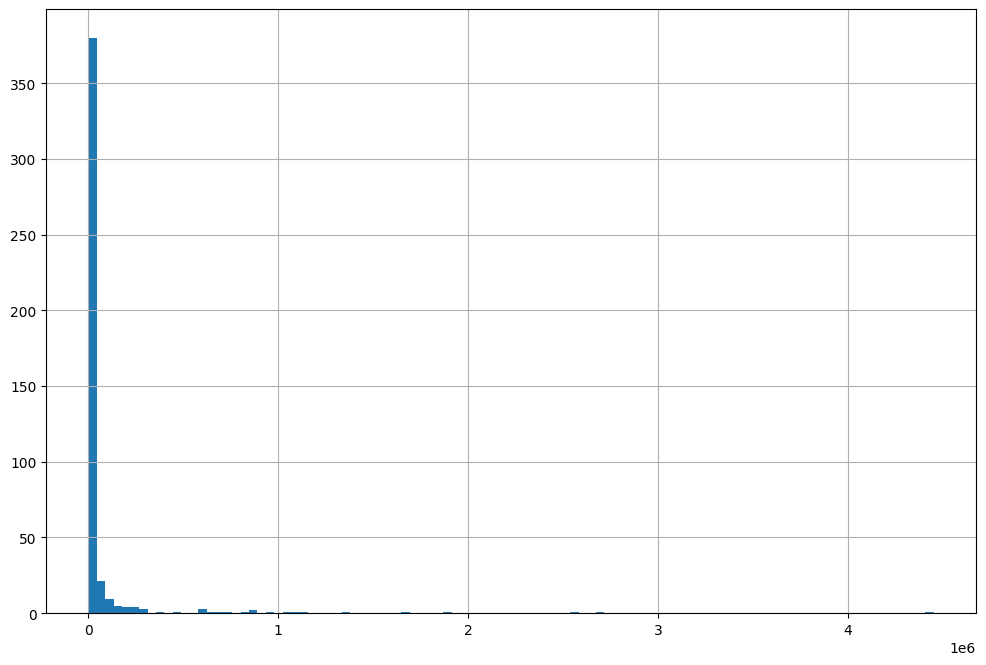

In [28]:
for i, s in enumerate(final_sim3_safes):
    updated_s = update_cratios(s, ETH_USD * 0.5, REDEMPTION_PRICE) 
    underwater = updated_s[updated_s['cratio'] < MAINNET_LIQ_RATIO]
    print(s['cratio'].median())
    print(s['collateral'].sum())
    print(s['debt'].sum())
    s['debt'].hist(bins=100)
    #updated_s['cratio'].hist(bins=100)
    #updated_s['collateral'].hist(bins=100)
    
    break
    #print(updated_s['cratio'].describe())
    #critical_coll, critical_debt = liquidate_critical(updated_s, liq_cratio=1.35)
    #print(critical_coll, critical_debt)

# Sim #4: Gaussian Mixture Model for SAFE collateral amounts and c-ratios

/var/folders/z_/tzvx3mfs7rsbb8dxt0rd157w0000gn/T/ipykernel_11597/2971107313.py:35: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  CB = plt.colorbar(CS, shrink=0.8, extend='both')


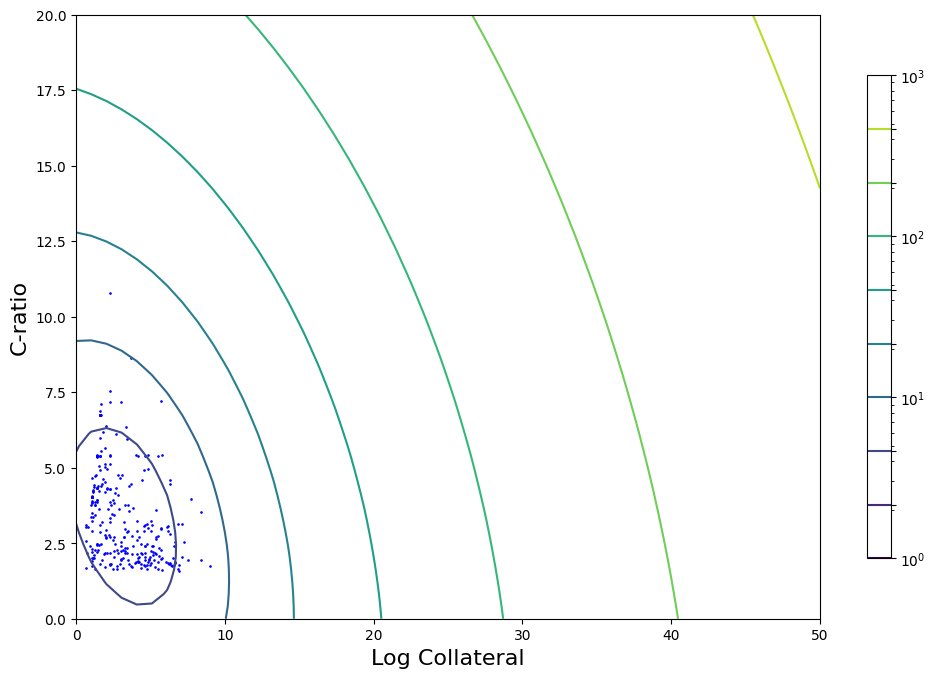

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

# Create a Gaussian Mixture Model with one component
mix = mixture.GaussianMixture(n_components=1, covariance_type='full')

safes = non_saviour_safes.copy()

# log transform to make more normal
safes['collateral'] = np.log(safes['collateral'])

"""
safes['collateral'].hist(bins=100, color='blue', alpha=0.5, label='original')
plt.title('Transformed collateral')
plt.legend()
plt.grid(False)
plt.show()
"""

# Fit
mix.fit(safes[['collateral', 'cratio']])

# display predicted scores by the model as a contour plot
x = np.linspace(0, 50.)
y = np.linspace(0, 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -mix.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')

plt.scatter(safes['collateral'], safes['cratio'], .8, color='blue')

#plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.xlabel('Log Collateral', fontsize=16)
plt.ylabel('C-ratio', fontsize=16)
plt.show()


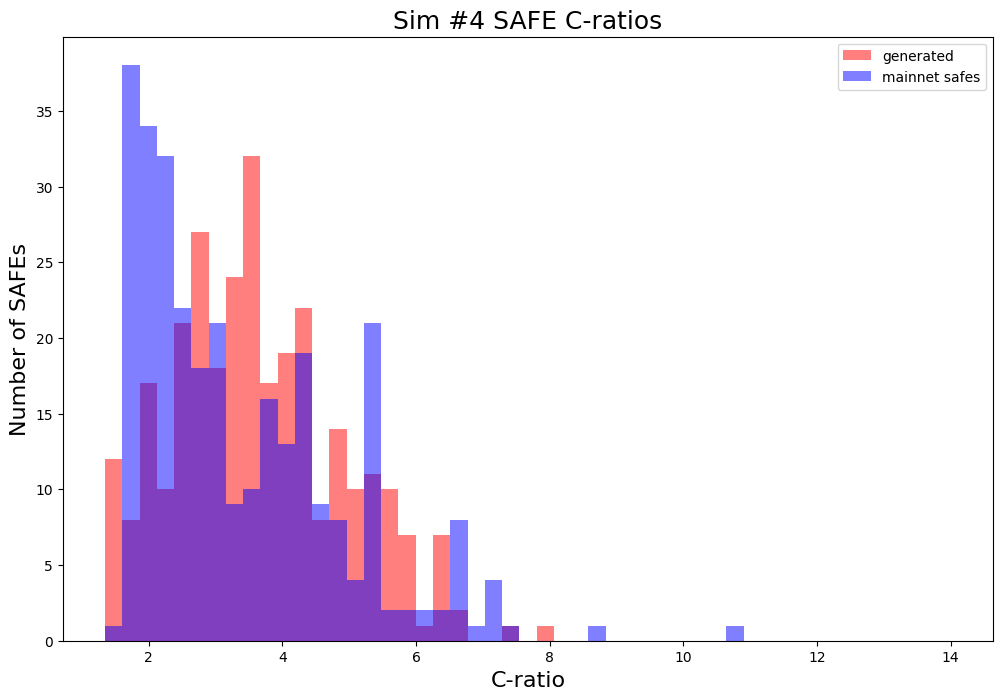

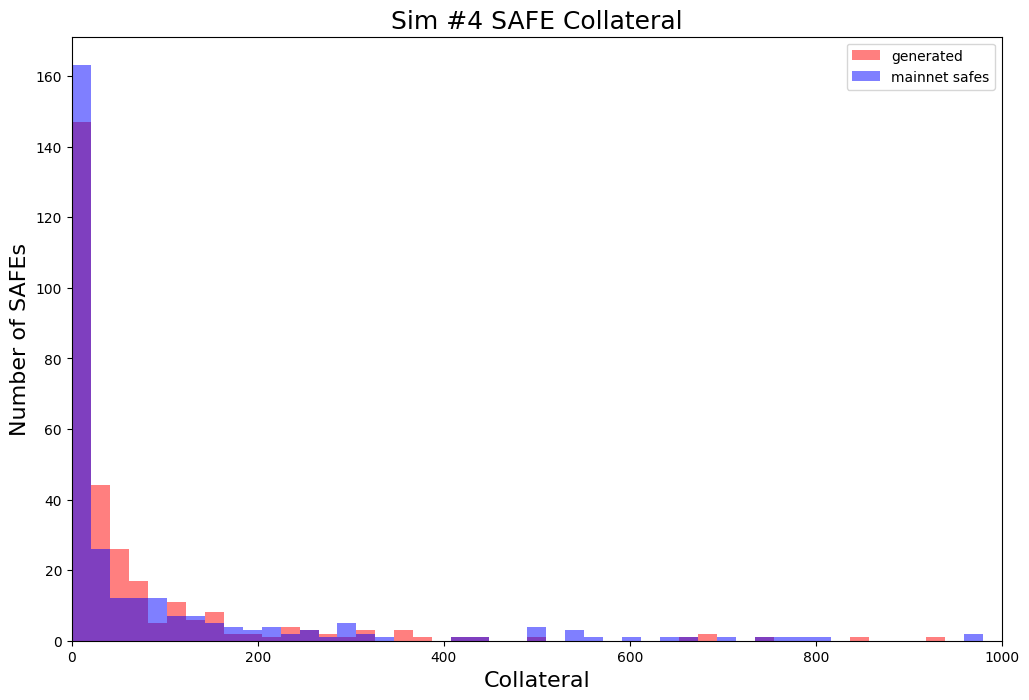

In [30]:
# sample fitted distribution and create dataframe
sample = np.random.multivariate_normal(mix.means_[0], mix.covariances_[0], len(non_saviour_safes)*2)
df = pd.DataFrame(sample, columns=['collateral', 'cratio'])
df = df[df['cratio'] > MAINNET_LIQ_RATIO]
df = df.head(len(non_saviour_safes))
df['collateral'] = np.exp(df['collateral'])

# plot generated and mainnet C-ratios
bins = np.linspace(1.35, 14, 50)
df['cratio'].hist(bins=bins, alpha=0.5, color='red', label='generated')
non_saviour_safes['cratio'].hist(bins=bins, color='blue', alpha=0.5, label='mainnet safes')

plt.title('Sim #4 SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

# plot generated and mainnet collaterals
bins = np.linspace(0, 1000, 50)
df['collateral'].hist(bins=bins, alpha=0.5, color='red', label='generated')
non_saviour_safes['collateral'].hist(bins=bins, alpha=0.5, color='blue', label='mainnet safes')

plt.xlim([0, 1000])
plt.title('Sim #4 SAFE Collateral', fontsize=18)
plt.xlabel('Collateral', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

## Prepare Sim#4 SAFEs

In [31]:
# Generate a population of SAFEs for each run

# draw random collateral and c-ratio values from distribution

all_gaussian_safes = [np.random.RandomState(SAFE_POP_SEEDS[i]).multivariate_normal(mix.means_[0], mix.covariances_[0], len(non_saviour_safes)*2) 
                      for i in range(N_SAFE_POPS)]

# Intialize SAFEs with random values
all_safes = [pd.DataFrame(gaussian_safe, columns=['collateral', 'cratio']) for gaussian_safe in all_gaussian_safes]


all_tmp_safes = []
for tmp_safes in all_safes:
    tmp_safes['collateral'] = np.exp(tmp_safes['collateral'])
    # Filter out unacceptable SAFEs
    tmp_safes = tmp_safes[(tmp_safes['collateral'] > 0) & (tmp_safes['cratio'] > MAINNET_LIQ_RATIO)]    
    tmp_safes = tmp_safes.head(len(non_saviour_safes))
    assert len(tmp_safes) == len(non_saviour_safes)
    
    tmp_safes['debt'] = tmp_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / tmp_safes['cratio']    
    all_tmp_safes.append(tmp_safes)
    
# Draw more random collateral and c-ratio values
all_extra_gaussian_safes = [np.random.RandomState(SAFE_POP_SEEDS[i]).multivariate_normal(mix.means_[0], mix.covariances_[0], 1000) 
                      for i in range(N_SAFE_POPS)]

# add extra safes to meet debt ceiling
final_sim4_safes = []
for idx, tmp_safes in enumerate(all_tmp_safes):
    extra_debt = DEBT_CEILING  - tmp_safes['debt'].sum()
    if extra_debt <= 0:
        final_sim4_safes.append(tmp_safes)
        continue
        
    new_safes = pd.DataFrame(all_extra_gaussian_safes[idx], columns=['collateral', 'cratio'])
    new_safes['collateral'] = np.exp(new_safes['collateral'])
    
     # Filter out unacceptable samples
    new_safes = new_safes[(new_safes['collateral'] > 0) & (new_safes['cratio'] > MAINNET_LIQ_RATIO)]   
    # Calculate debt
    new_safes['debt'] = new_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / new_safes['cratio']
       
    new_safes['total_debt'] = new_safes['debt'].cumsum()        
    final_safes = new_safes[new_safes['total_debt'] <= extra_debt]
    #assert len(final_safes) > 0
    tmp_safes = pd.concat([tmp_safes, final_safes])
    final_sim4_safes.append(tmp_safes)

# Generate Uniswap V2 RAI/USD Shocks

This simulates the RAI/USD return of Uniswap V2 RAI/ETH pool given ETH/USD shock.
This is to provide a more realistic V2 pool price after an ETH/USD shocks.
The parameters were fit on prod data when V2 RAI/ETH was the only Reflexer liquidity pool.

Note: Use this when V2 is the only liquidity pool being simulated

In [32]:
def prepare_rai_shocks(shocks, n):
    """
    generate `n` V2 RAI/USD shocks for each ETH/USD shock in `shocks`
    Parameters
    ----------
    shocks: List[float] 
        ETH/USD shocks
    n: int
        Number of V2 RAI/USD shocks to generate for each ETH/USD shock
    Returns
    -------
    dict[float -> List[float]]
        Multiple rai_usd shocks for each eth_usd shock
    """
    
    def cond_dist(means, covs, a):
        # dist of x1 given x2=a
        # https://online.stat.psu.edu/stat505/lesson/6/6.1
        mu_1, mu_2 = means[0]
        cov_11 = covs[0][0, 0]
        cov_12 = covs[0][0, 1]
        cov_21 = covs[0][1, 0]
        cov_22 = covs[0][1, 1]

        mu_cond = + cov_12*(1/cov_22)*(a-mu_2)
        cov_cond = cov_11 - cov_12*(1/cov_22)*cov_21

        return mu_cond, cov_cond
    
    # parameters from ETHUSD and RAIUSD notebook
    means = np.array([[-0.00045541,  0.00047911]])
    covs = np.array([[[ 4.13783784e-05, -3.19083822e-05],
                      [-3.19083822e-05,  9.39901212e-05]]])
    
    all_rai_shocks = {}
    for s in shocks:
        rai_shocks = []
        # conditional distribution of rai_eth return, given eth_usd return of s
        mu_cond, cov_cond = cond_dist(means, covs, -s)

        rai_eth_returns = multivariate_normal.rvs(mu_cond, 
                                            cov_cond*1, 
                                            size=n,
                                            random_state=42)
        if n == 1:
            rai_eth_returns = [rai_eth_returns]

        rai_usd_shocks = [(1 - s) * (1 + re) for re in rai_eth_returns]
        all_rai_shocks[s] = rai_usd_shocks
 
        
    return all_rai_shocks

In [33]:
orig_rai_shocks = prepare_rai_shocks(SHOCKS, N_SHOCK_RUNS)

In [34]:
# disable v2 rai/eth modeling. eth/usd drops have no effect on v2 rai/eth
rai_shocks = {k:[1.0 for i in range(len(v))] for k, v in orig_rai_shocks.items()}

# Comment out this if V2 is only liquidity pool.
# Uncommenting this, disableds V2 RAI/ETH modeling, which will be more realistic when simulating multiple pools. 
#rai_shocks = {k:[1.0] for k in orig_rai_shocks.keys()}

In [35]:
final_sim2_safes = final_sim2_safes[:N_SAFE_POPS]
final_sim3_safes = final_sim3_safes[:N_SAFE_POPS]
final_sim4_safes = final_sim4_safes[:N_SAFE_POPS]

## Past shocks

In [36]:
"""
eth_shocks = pd.read_csv('binance_eth_shocks.csv')
smallest_shock = 0.02
past_shocks = eth_shocks.query(f'pct_change <= -{smallest_shock}')['pct_change']
past_shocks = [-x for x in past_shocks]
"""

"\neth_shocks = pd.read_csv('binance_eth_shocks.csv')\nsmallest_shock = 0.02\npast_shocks = eth_shocks.query(f'pct_change <= -{smallest_shock}')['pct_change']\npast_shocks = [-x for x in past_shocks]\n"

## Run All Sims

In [37]:
V2_POOL_DEBTS = np.round(np.linspace(0.00, 0.70, 15), 3)
V3_POOL_DEBTS = np.round(np.linspace(0.00, 0.30, 7), 3)

#V2_POOL_DEBTS = [0.05, 0.20, 0.35, 0.50]
#V3_POOL_DEBTS = [0.05, 0.10, 0.15]


In [38]:
start = time.time()
VERBOSE = False
for _ in range(1):
    assert len(final_sim2_safes) == len(final_sim3_safes) == len(final_sim4_safes) == N_SAFE_POPS
    
    
    sim2_results = run_sims_iter(final_sim2_safes, V2_POOL_DEBTS , V3_POOL_DEBTS, INITIAL_SURPLUS_PCTS,
                                 SHOCKS, rai_shocks, MAINNET_LIQ_RATIO, title='', sim_name='sim2', verbose=VERBOSE)
    print("sim2_results complete")
    
    sim3_results = run_sims_iter(final_sim3_safes, V2_POOL_DEBTS , V3_POOL_DEBTS, INITIAL_SURPLUS_PCTS,
                                 SHOCKS, rai_shocks, MAINNET_LIQ_RATIO, title='', sim_name='sim3', verbose=VERBOSE)
    print("sim3_results complete")
    
    sim4_results = run_sims_iter(final_sim4_safes, V2_POOL_DEBTS , V3_POOL_DEBTS, INITIAL_SURPLUS_PCTS,
                                SHOCKS, rai_shocks, MAINNET_LIQ_RATIO, title='', sim_name='sim4', verbose=VERBOSE)    
    print("sim4_results complete")
    
print(f"took {time.time() - start} secs")

v2_liq_debt=0.0, v3_liq_debt=0.0, liq_ratio=1.35, initial_surplus_pct=0.005 complete
v2_liq_debt=0.0, v3_liq_debt=0.05, liq_ratio=1.35, initial_surplus_pct=0.005 complete
v2_liq_debt=0.0, v3_liq_debt=0.1, liq_ratio=1.35, initial_surplus_pct=0.005 complete
v2_liq_debt=0.0, v3_liq_debt=0.15, liq_ratio=1.35, initial_surplus_pct=0.005 complete
v2_liq_debt=0.0, v3_liq_debt=0.2, liq_ratio=1.35, initial_surplus_pct=0.005 complete
v2_liq_debt=0.0, v3_liq_debt=0.25, liq_ratio=1.35, initial_surplus_pct=0.005 complete
v2_liq_debt=0.0, v3_liq_debt=0.3, liq_ratio=1.35, initial_surplus_pct=0.005 complete
v2_liq_debt=0.05, v3_liq_debt=0.0, liq_ratio=1.35, initial_surplus_pct=0.005 complete
v2_liq_debt=0.05, v3_liq_debt=0.05, liq_ratio=1.35, initial_surplus_pct=0.005 complete
v2_liq_debt=0.05, v3_liq_debt=0.1, liq_ratio=1.35, initial_surplus_pct=0.005 complete
v2_liq_debt=0.05, v3_liq_debt=0.15, liq_ratio=1.35, initial_surplus_pct=0.005 complete
v2_liq_debt=0.05, v3_liq_debt=0.2, liq_ratio=1.35, initi

# Processing and Visualization

## Max Positive Shock Heatmaps

In [39]:
#for each config(v2/v3 liq debt, initial surplus, liq_ratio, etc
# get the max shock that maintains pos. surplus with prob `q`
def get_max_pos_shock(df, q):
    df_q = df[['v2_liq_debt', 'v3_liq_debt', 'shock', 'surplus']].groupby(['v2_liq_debt', 'v3_liq_debt', 'shock']).quantile(1. - q).reset_index()
    df_q = df_q[df_q['surplus'] > 0]
    
    df_max_shock = df_q.loc[df_q.groupby(['v2_liq_debt', 'v3_liq_debt']).shock.idxmax()]
    return df_max_shock

In [57]:
q = 0.95
sim2_max_shock = get_max_pos_shock(sim2_results, q)
sim3_max_shock = get_max_pos_shock(sim3_results, q)
sim4_max_shock = get_max_pos_shock(sim4_results, q)

In [58]:
sim3_max_shock.head(5)

,v2_liq_debt,v3_liq_debt,shock,surplus
4,0.0,0.00,0.14,121252.299165
37,0.0,0.05,0.16,170390.126748
74,0.0,0.10,0.22,165917.155263
109,0.0,0.15,0.26,197710.806609
147,0.0,0.20,0.33,107603.662222


In [59]:
sim2_max_shock.query('shock == 0.0').head(50)

,v2_liq_debt,v3_liq_debt,shock,surplus


In [217]:
def prep_heatmap(df, value_col):
    # Put results in 2-d array format for plt.imshow()
    v2_liq_debts = df['v2_liq_debt'].sort_values().unique()
    v3_liq_debts = df['v3_liq_debt'].sort_values().unique()
    #data = np.zeros((len(v2_liq_debts), len(v3_liq_debts)))
    data = np.zeros((len(v3_liq_debts), len(v2_liq_debts)))
    for i, row in df.iterrows():
        v2_idx = np.where(v2_liq_debts == row['v2_liq_debt'])[0][0]
        v3_idx = np.where(v3_liq_debts == row['v3_liq_debt'])[0][0]
        #data[v2_idx, v3_idx] = row[value_col]
        data[v3_idx, v2_idx] = row[value_col]
        #print(v2_idx, v3_idx, row)
    #return data, v2_liq_debts, v3_liq_debts
    return data, v3_liq_debts, v2_liq_debts

def plot_heatmap(data, rows, cols, cmap, norm=None, bar_title='', title=''):
    
    #plot heatmap
    fig, ax = plt.subplots()

    im = ax.imshow(data, cmap=cmap, norm=norm)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(bar_title, rotation=-90, va="bottom")

    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    
    ax.set_xticklabels(labels=cols, rotation='vertical')
    ax.set_yticklabels(labels=rows)
    #ax.set_xlabel('non-V2 liq/debt ratio')
    #ax.set_ylabel('V2 liq/debt ratio')
    ax.set_ylabel('non-V2 liq/debt ratio')
    ax.set_xlabel('V2 liq/debt ratio')
    ax.set_title(title)

In [218]:
sim2_heatmap, rows2, cols2 = prep_heatmap(sim2_max_shock, 'shock')

In [219]:
rows2, cols2

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 ]))

In [220]:
sim3_heatmap, rows3, cols3 = prep_heatmap(sim3_max_shock, 'shock')

In [221]:
sim4_heatmap, rows4, cols4 = prep_heatmap(sim4_max_shock, 'shock')

Sim2 Results Heatmap

In [222]:
print(sim2_heatmap[0, 0])

0.14


In [223]:
title = f"Largest ETH/USD shock that maintains positive surplus with probability = {q}"

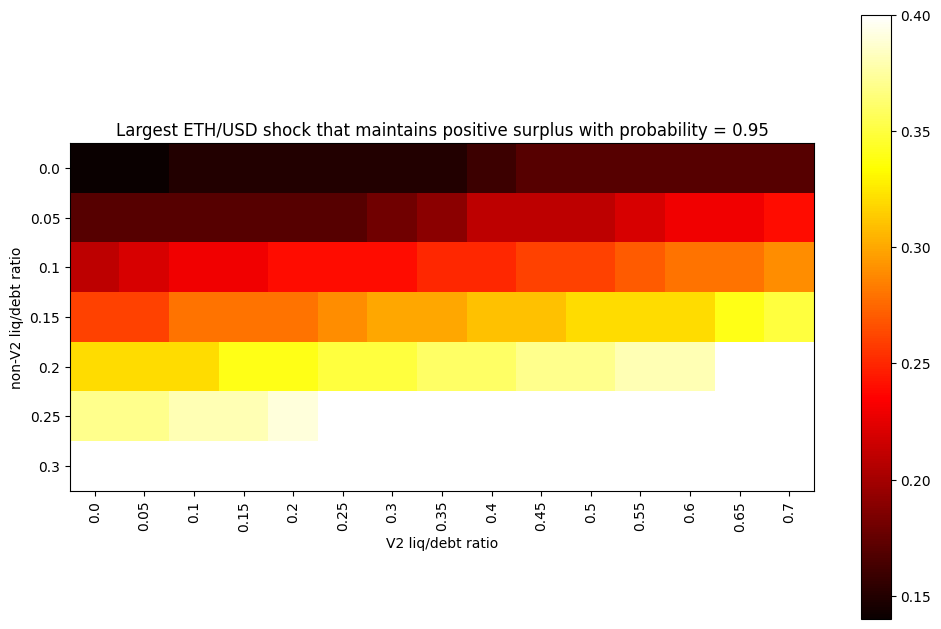

In [224]:
plot_heatmap(sim2_heatmap, rows2, cols2, cmap='hot', title=title)

Sim3 Results Heatmap

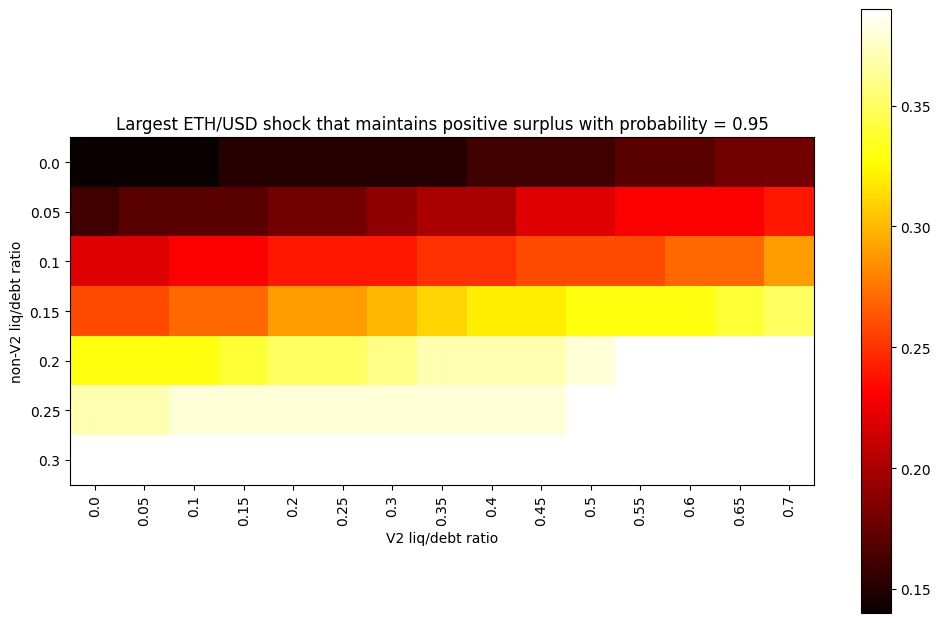

In [225]:
plot_heatmap(sim3_heatmap, rows3, cols3, cmap='hot', title=title)

Sim4 Results Heatmap

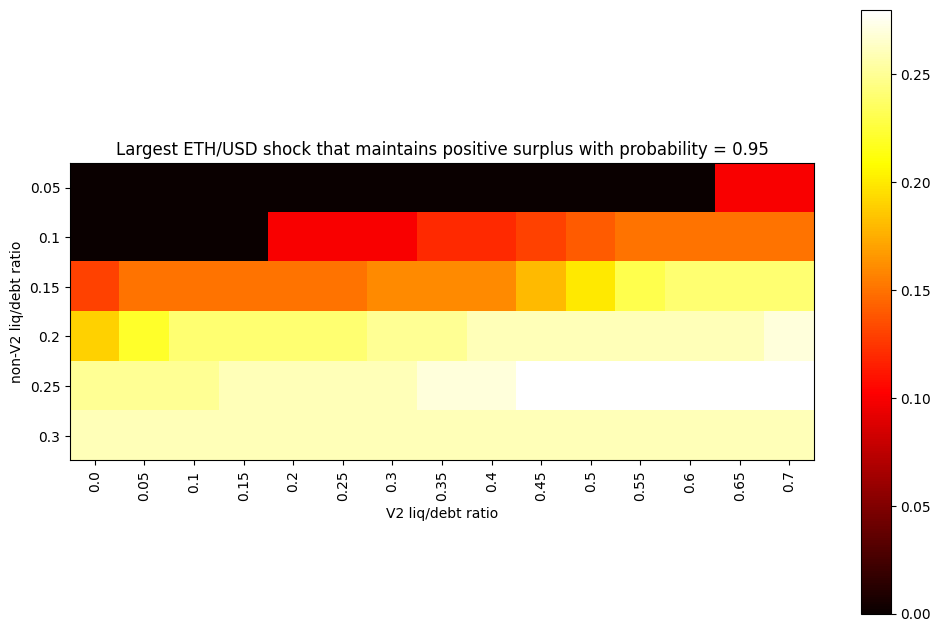

In [226]:
plot_heatmap(sim4_heatmap, rows4, cols4, cmap='hot', title=title)

In [227]:
assert np.array_equal(rows2, rows3)
assert np.array_equal(cols2, cols3)
combined_heatmap23 = np.minimum(sim2_heatmap, sim3_heatmap)

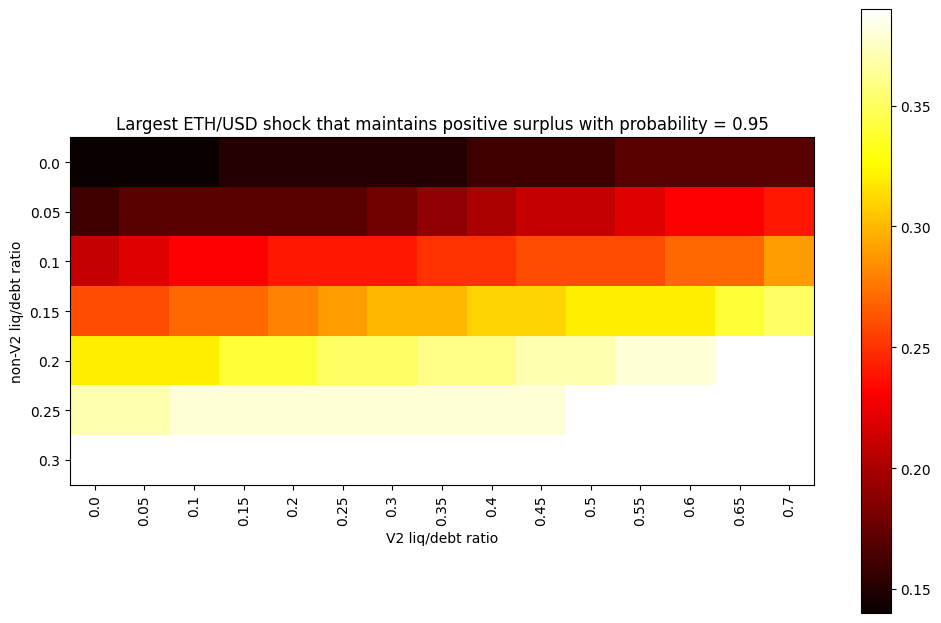

In [228]:
plot_heatmap(combined_heatmap23, rows3, cols3, cmap='hot', title=title)

In [229]:
#combined_heatmap_all = np.minimum(np.minimum(sim2_heatmap, sim3_heatmap), sim4_heatmap)

## Raw Surplus Heatmaps for single shock level

In [230]:
from matplotlib import colors  
q=0.95

In [231]:
df_shock_20 = sim3_results[sim3_results['shock'] == 0.20]
df_shock_30 = sim3_results[sim3_results['shock'] == 0.30]
df_shock_40 = sim3_results[sim3_results['shock'] == 0.40]

df_shock_20_q = df_shock_20.groupby(['v2_liq_debt', 'v3_liq_debt', 'initial_surplus_pct', 'lr'])['surplus'].quantile(1-q).reset_index()
df_shock_30_q = df_shock_30.groupby(['v2_liq_debt', 'v3_liq_debt', 'initial_surplus_pct', 'lr'])['surplus'].quantile(1-q).reset_index()
df_shock_40_q = df_shock_40.groupby(['v2_liq_debt', 'v3_liq_debt', 'initial_surplus_pct', 'lr'])['surplus'].quantile(1-q).reset_index()

In [232]:
df_shock_20_mean.head(5)

,v2_liq_debt,v3_liq_debt,initial_surplus_pct,lr,surplus
0,0.0,0.00,0.005,1.35,-2.846488e+06
1,0.0,0.05,0.005,1.35,-1.142587e+06
2,0.0,0.10,0.005,1.35,1.743852e+05
3,0.0,0.15,0.005,1.35,1.768025e+05
4,0.0,0.20,0.005,1.35,1.782288e+05


min_surplus=-8746691.3700344, max_surplus=265840.12003851065


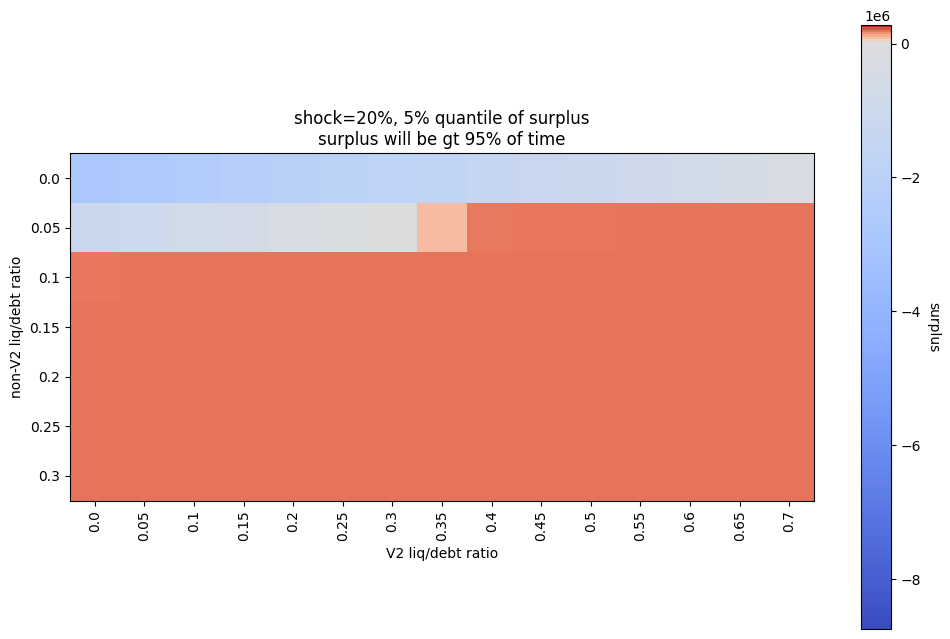

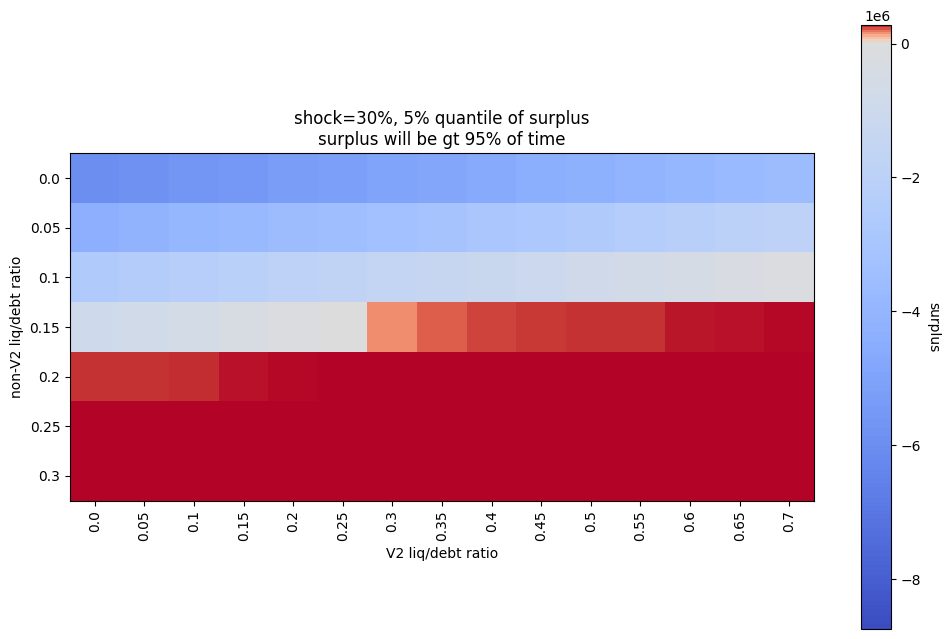

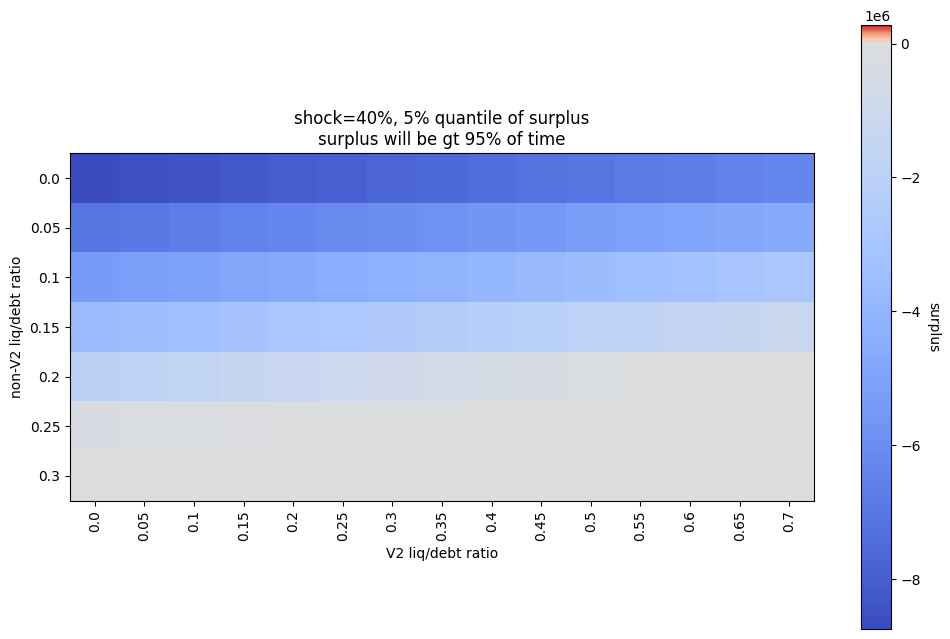

In [236]:
all_surplus = pd.concat((df_shock_20_q['surplus'], df_shock_30_q['surplus'], df_shock_40_q['surplus']))
min_surplus = min(all_surplus)
max_surplus = max(all_surplus)

print(f"{min_surplus=}, {max_surplus=}")

divnorm = colors.TwoSlopeNorm(vmin=min_surplus, vcenter=0., vmax=max_surplus)

surplus_heatmap_20, rows, cols = prep_heatmap(df_shock_20_q, 'surplus')
plot_heatmap(surplus_heatmap_20, rows, cols, cmap='coolwarm', norm=divnorm,
             title="shock=20%, 5% quantile of surplus\nsurplus will be gt 95% of time",
             bar_title='surplus')
surplus_heatmap_30, rows, cols = prep_heatmap(df_shock_30_q, 'surplus')
plot_heatmap(surplus_heatmap_30, rows, cols, cmap='coolwarm', norm=divnorm,
             title="shock=30%, 5% quantile of surplus\nsurplus will be gt 95% of time",
             bar_title='surplus')
surplus_heatmap_40, rows, cols = prep_heatmap(df_shock_40_q, 'surplus')
plot_heatmap(surplus_heatmap_40, rows, cols, cmap='coolwarm', norm=divnorm,
             title="shock=40%, 5% quantile of surplus\nsurplus will be gt 95% of time",
             bar_title='surplus')

## Plot all SAFE Population Surpluses through all shocks for a single config

In [237]:
# for a single system config(v2/vq liq., initial surplus, etc)
# plot all safe populations behavior over shocks
def plot(sim_results, v2_liq_debt, v3_liq_debt, initial_surplus_pct, q):
    df = sim_results[(sim_results['v2_liq_debt'] == v2_liq_debt) & (sim_results['v3_liq_debt'] == v3_liq_debt) &\
                     (sim_results['initial_surplus_pct'] == initial_surplus_pct)]
    plt.plot(df['shock'], df['surplus'], alpha=0.1)
    df_q = df[['shock', 'surplus']].groupby('shock').quantile(1. - q).reset_index()
    df_100 = df[['shock', 'surplus']].groupby('shock').quantile(1.0).reset_index()
    plt.plot(df_q['shock'], df_q['surplus'], ':')
    plt.plot(df_100['shock'], df_100['surplus'], ':')
    plt.fill_between(SHOCKS, 
                df_100['surplus'], 
                df_q['surplus'], alpha=0.4,label=f"{q*100}% confidence")

    df_mean = df[['shock', 'surplus']].groupby('shock').mean().reset_index()
    plt.plot(df_mean['shock'], df_mean['surplus'])
    plt.title(f'{v2_liq_debt=}, {v3_liq_debt=}, {initial_surplus_pct=}', fontsize=14)
    plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
    plt.ylabel('Surplus', fontsize=16)
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.ylim([-1E7,2E6])
    plt.show()

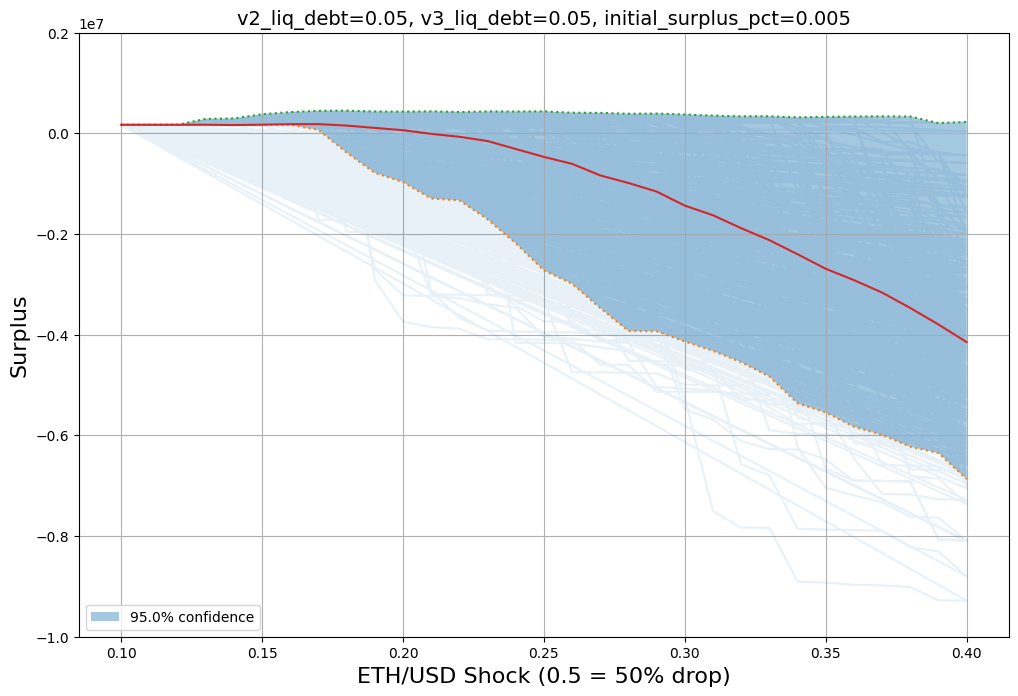

In [238]:
plot(sim3_results, 0.05, 0.05, 0.005, q=0.95)